In [1]:
import numpy as np 
import yaml
from scipy.interpolate import interp1d, make_interp_spline
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.stats import norm
from classy import Class

# In this file we find the priors for the different reduced-space parameters given our bank

In [2]:
# NOte this now has to be all in Mpc/h units!!

In [3]:
with h5py.File('/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/lhc_bank_z0p5to2p5/total_data.h5', 'r') as hdf_file:
    print(hdf_file.keys())
    lhc_pk_lin = hdf_file["pk_lin"][:]
    cosmo_params = hdf_file["params"][:]
    


<KeysViewHDF5 ['params', 'pk_lin']>


In [4]:
cosmo_params[2]

array([ 0.145   ,  0.023225,  0.7125  , -0.125   ,  1.115   ,  1.5329  ,
       -0.44    , -1.075   ,  1.      ])

In [5]:
param_names = ["omega_cdm", "omega_b", "h", "Omega_k", "n_s", "N_ur", "m_ncdm", "w0_fld", "z"]

In [6]:
#Load in optimum knots 
# knots = np.load("/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/hpc_work/final_knots_125.npy")

knots = np.load("/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/hpc_work/final_knots_80.npy")

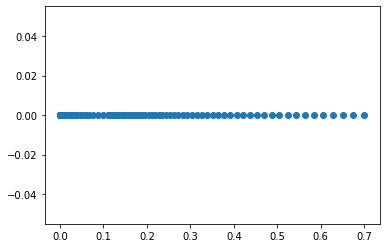

In [7]:
plt.scatter(knots, np.zeros_like(knots))

In [32]:
#Function to loop through bnk and extract the parameters and store in an array

k_l, k_r =  1e-4, 1.0 #In Mpc/h


kk = np.logspace(-5, 1, 1000)
kk_ = np.linspace(k_l, k_r, 100)#for the spline
dk = kk_[1:]-kk_[:-1]
dk = np.concatenate(([dk[0]], dk))
nbins = len(kk_)

def get_spline_params(knots, ilogpk, with_logknots=False):
    logknots = np.log( np.unique(knots) ) # sorting and removing duplicates
    logpk = ilogpk(logknots)
    if with_logknots: return logknots, logpk
    else: return logpk

def get_logslope(x, f, side='left'):
    if side == 'left': 
        n = (np.log(f[1]) - np.log(f[0])) / (np.log(x[1]) - np.log(x[0]))
        A = f[0] / x[0]**n
    elif side == 'right':
        n = (np.log(f[-1]) - np.log(f[-2])) / (np.log(x[-1]) - np.log(x[-2]))
        A = f[-1] / x[-1]**n
    return A, n

M = Class()
M.set({
"N_ncdm": 1,
"T_ncdm": 0.71611,
"Omega_Lambda": 0,
})

def get_params_tot(knots, lhc_pk_lin, kk, kk_):

    param_array = []
    for i in range(30000):
        param_realization = []
        pk_i = 1.*lhc_pk_lin[i]
        pk_max = np.max(pk_i)
        
        cosmo_params_i = cosmo_params[i]
        M.set({key:val for key, val in zip(param_names, cosmo_params_i) if key != "z"})
        M.compute()
        f = M.scale_independent_growth_factor_f(cosmo_params_i[-1])
        

        pk = 1.*pk_i / pk_max # normalizing
        #Get the spline params
        ilogpk = interp1d(np.log(kk), np.log(pk), kind = 'cubic')
        spline_params = get_spline_params(knots,ilogpk)
        param_realization.extend(list(spline_params))
        param_realization.append(pk_max)
        param_realization.append(f)

        param_array.append(param_realization)



    #Get the pkmax param- I dont think we need this as we will not train the emulator over this?
    param_array = np.array(param_array)

    return param_array

In [33]:
knots.shape

(80,)

In [34]:
kk_.shape

(100,)

In [35]:
import time 

In [36]:
start = time.time()
param_array = get_params_tot(knots, lhc_pk_lin, kk, kk_)
end = time.time()

In [37]:
print("time", end-start)

time 1476.1685528755188


In [38]:
param_array.shape

(30000, 82)

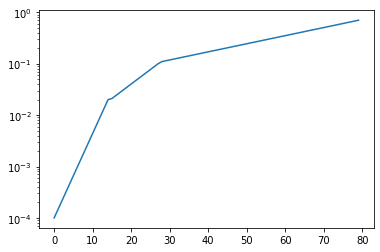

In [39]:
plt.plot(knots)
plt.yscale('log')

In [40]:
param_array.shape 

(30000, 82)

In [41]:
covariance = np.cov(param_array.T)

In [42]:
mu = np.mean(param_array, axis=0)

In [43]:
mu.shape 

(82,)

In [44]:
# save 

np.save("covariance_80_knots.npy", covariance)
np.save("mu_80_knots.npy", mu)


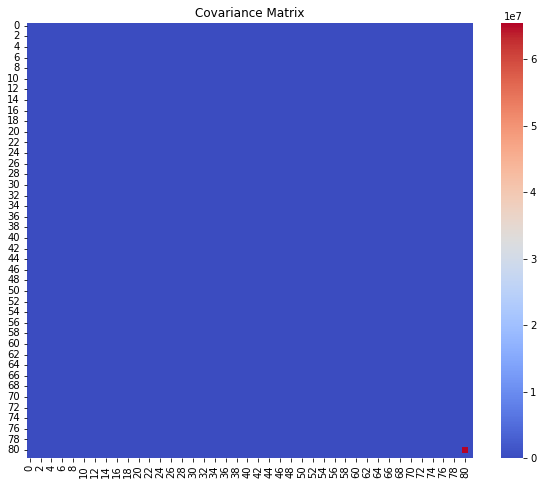

In [45]:
# Plotting the covariance matrix with log scale and colorbar
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(covariance, annot=False, cmap='coolwarm', cbar=True)
plt.title("Covariance Matrix")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


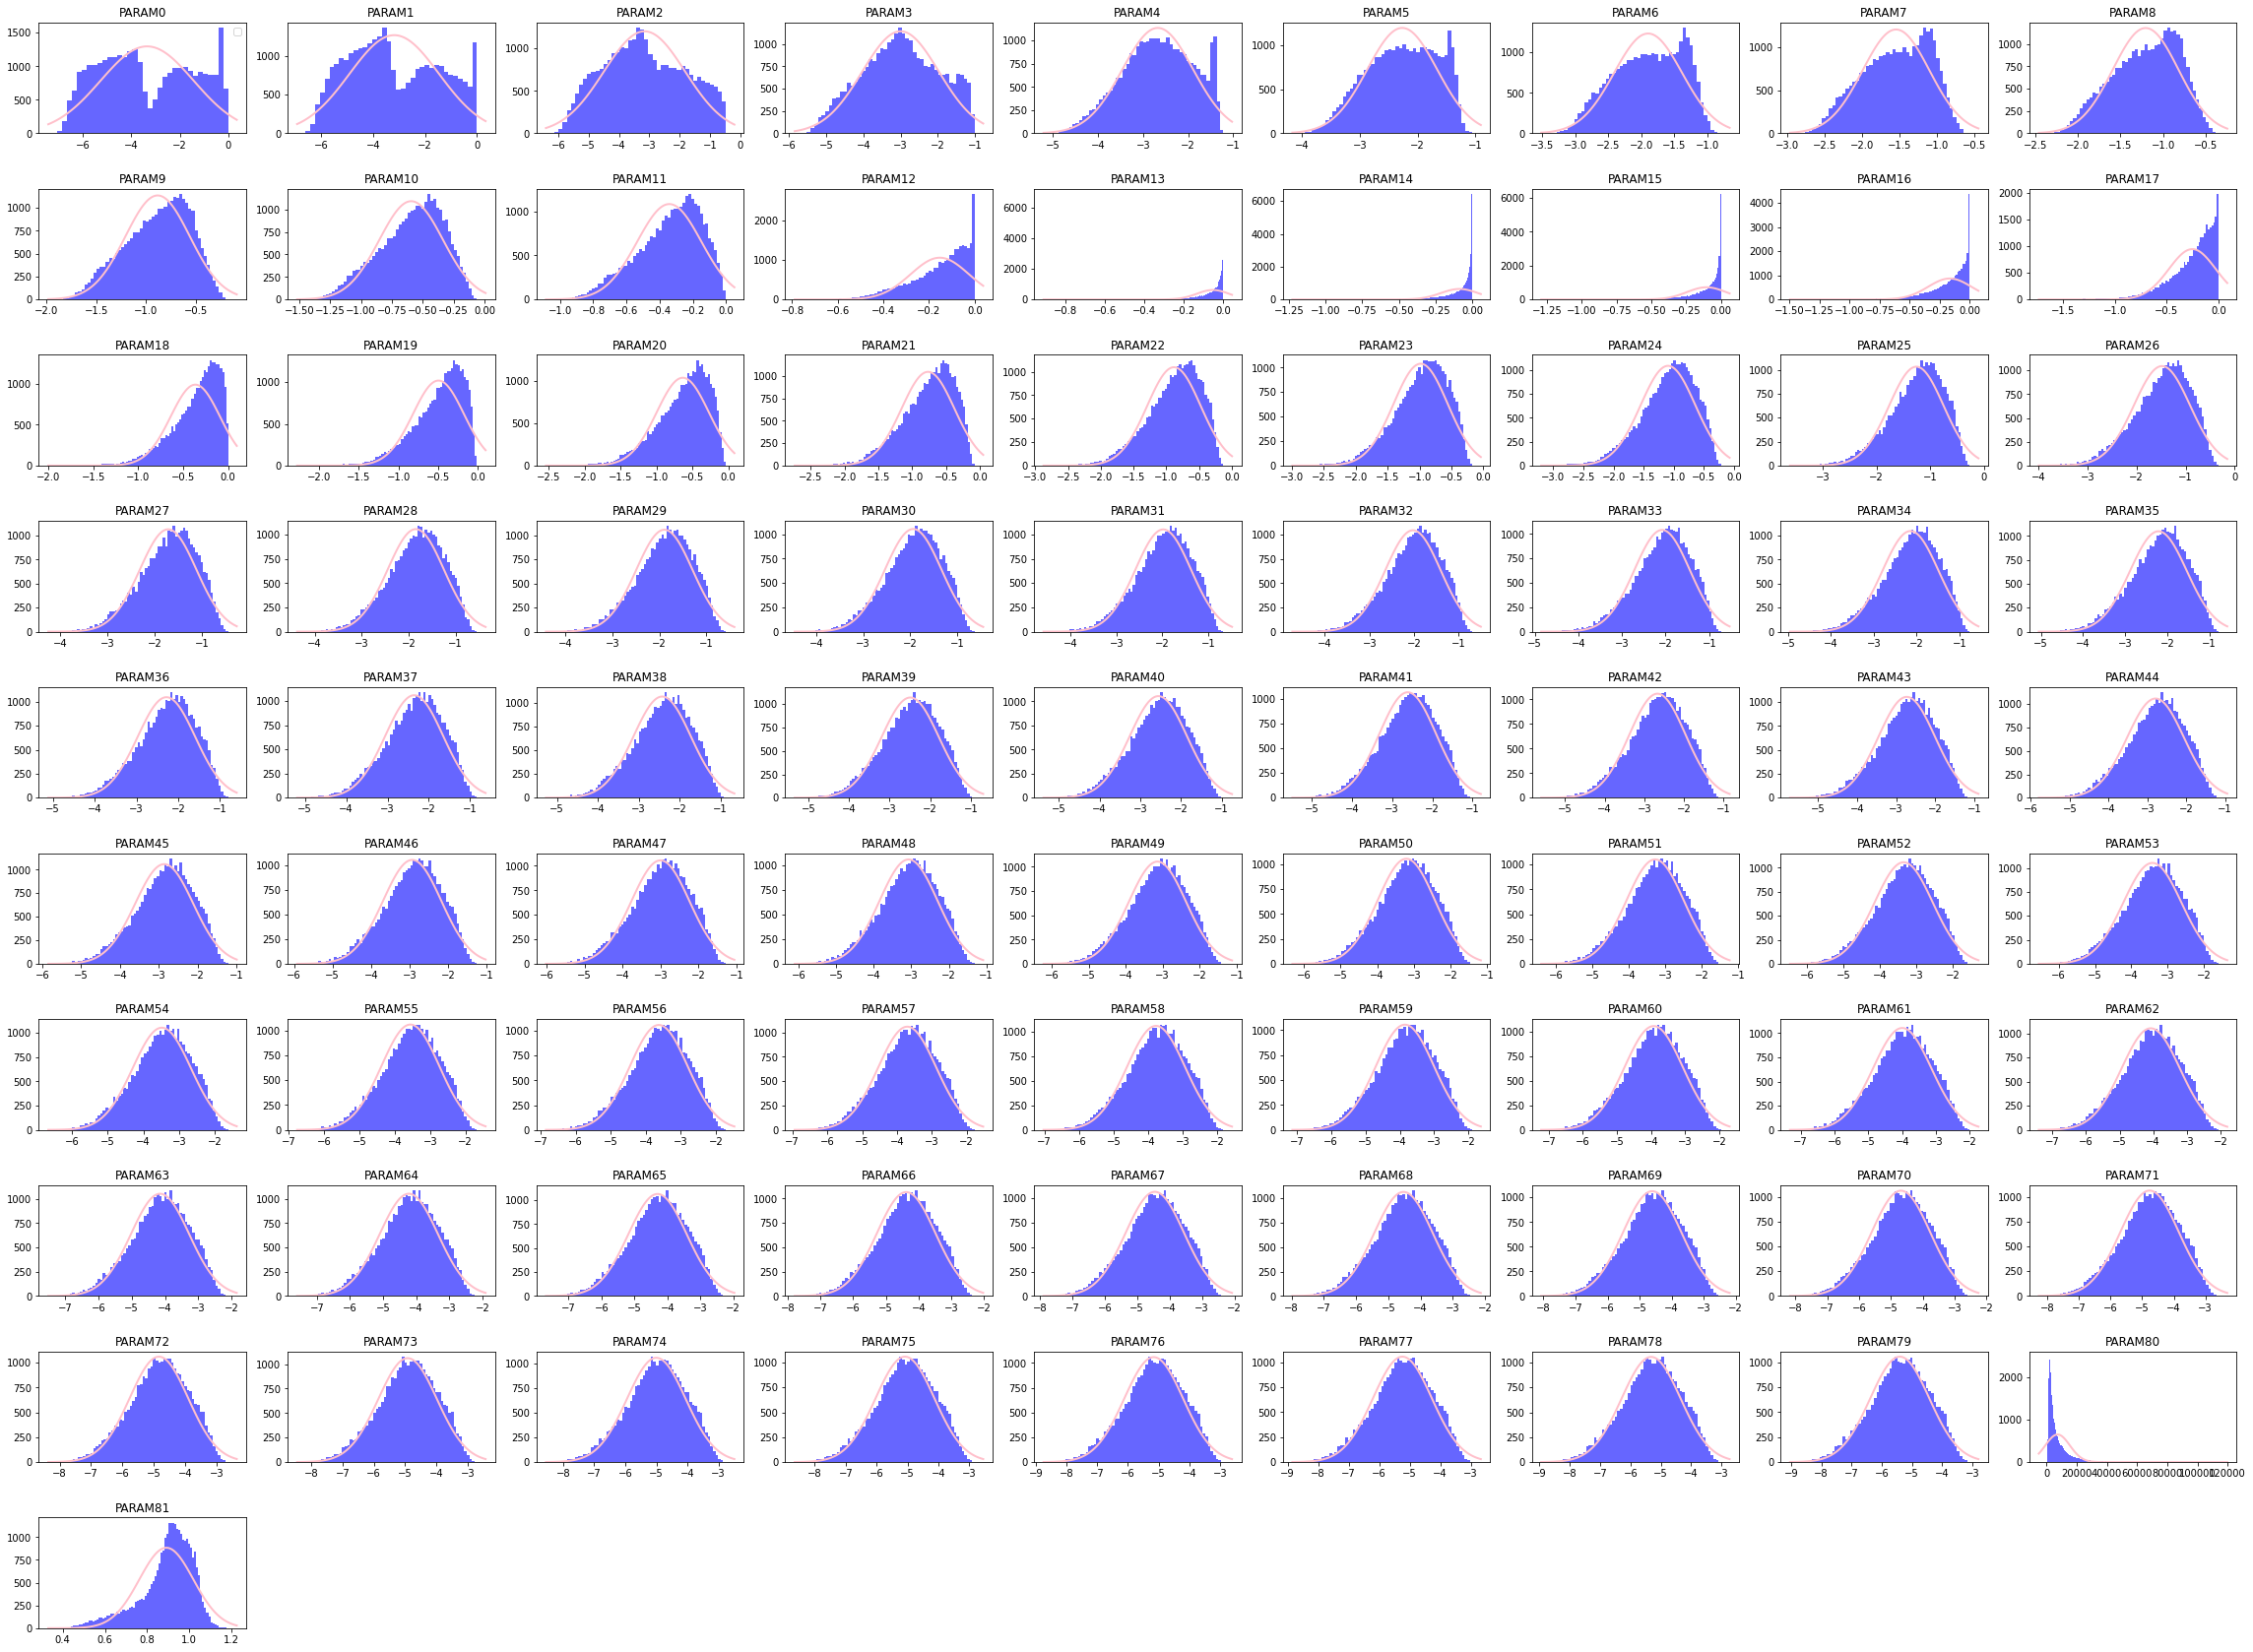

In [46]:
#Plot histograms to see how gaussian the distributions are

def plot_histograms(compressed_array):
    means = []
    sigmas = []
    num_data_points = compressed_array.shape[1]
    num_realizations = compressed_array.shape[0]
    num_rows = int(np.ceil(np.sqrt(num_data_points)))
    num_cols = int(np.ceil(num_data_points / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 30))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flatten()):
        if i < num_data_points:
            # Get the data for the current data point
            data = compressed_array[:, i]

            mu, sigma = norm.fit(data)

            # Store the mean and standard deviation
            means.append(mu)
            sigmas.append(sigma)

            # Plot the histogram for the current data point
            counts, bins, _ = ax.hist(data, bins='auto', density=False, alpha=0.6, color='blue')
            # Plot the PDF of the Gaussian distribution

            bin_width = bins[1] - bins[0]
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, sigma)

            scaled_p = p * bin_width * num_realizations  # scaling factor

            ax.plot(x, scaled_p, color='pink', linewidth=2)

            # Plot vertical lines at the 5th and 95th percentile values
            if i==0:
                ax.legend()

            ax.set_title(f'PARAM{i}')
        else:
            ax.axis('off')

    return means, sigmas

means, sigmas =plot_histograms(param_array)

In [47]:
len(means)

82

Some of these seem to never go positive- this might mess things up if I train over negative values as well but lets see...

This is because we normalized so the maximum is 0

In [48]:
def generate_yaml_file(means, sigmas, filename):
    parameter_info = list(zip(means, sigmas))
    yaml_data = {'parameters': []}

    for i, (mean, sigma) in enumerate(parameter_info):
        parameter_name = f'param{i+1}'
        # set the limits as being 10X wider than the gaussian priors
        upper_prior = mean.item() + (sigma.item() * 5)
        lower_prior = mean.item() - (sigma.item() * 5)

        # Apply the condition for all parameters except for the last four which are the log scaling parameters, pkmax and f
        if i < len(parameter_info) - 4 and upper_prior > 0:
            upper_prior = 0

        # Apply that the pkmax must be positive
        if i == len(parameter_info)-2 and lower_prior < 0:
            lower_prior = 0

        parameter_prior = [lower_prior, upper_prior]  # Convert numpy scalars to Python scalars

        parameter_data = {'name': parameter_name, 'prior': parameter_prior}
        yaml_data['parameters'].append(parameter_data)

    with open(filename, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, default_flow_style=False)

In [49]:
generate_yaml_file(means, sigmas, "config_80_kbins_5sigma.yaml")

## What do the extremeties look like? 

In [50]:
class PiecewiseSpline:
    """
    A class that when called will give us the piecewise spline
    """
    def __init__(self, knots, logpk_knots, dlogpk_l, dlogpk_r):
        # self.knots = sorted(knots)
        self.knots = sorted(knots)
        self.logknots = np.log(self.knots)
        
        # Define the boundary conditions
        self.bc = ([(1, dlogpk_l)], [(1, dlogpk_r)])
        
        # Create the spline
        self.ilogpk_spline = make_interp_spline(self.logknots, logpk_knots, k=3, bc_type=self.bc)
        
        # Store boundary values and their derivatives
        self.k_l = self.knots[0]
        self.k_r = self.knots[-1]

        self.nl = dlogpk_l
        self.nr = dlogpk_r
        self.logAl = logpk_knots[0] - self.nl*self.logknots[0]
        self.logAr = logpk_knots[-1] - self.nr*self.logknots[-1]

    def __call__(self, k):
        # Vectorize the evaluate function so that it can handle arrays
        return np.vectorize(self.evaluate)(k)


    def evaluate(self, logk):
        k = np.exp(logk)
        if k < self.k_l:
            return self.logAl + self.nl * logk
        elif k > self.k_r:
            return self.logAr + self.nr * logk
        else:
            return self.ilogpk_spline(logk)

In [51]:
# lower_lim = np.array(means)-10*np.array(sigmas)
lower_lim = np.array(means)
lower_lim = lower_lim[:-3]

In [52]:
lower_lim.shape 

(79,)

In [53]:
upper_lim = np.array(means)[0:-3] + np.array(sigmas)[0:-3] * 10
upper_lim[np.where(upper_lim>0)]=0

In [54]:
ipk_loglog_spline_min = PiecewiseSpline(knots, lower_lim, means[-2]-10*sigmas[-2], means[-1]-10*sigmas[-1])

# ipk_loglog_spline_min = PiecewiseSpline(knots, lower_lim, means[-2], means[-1])

ValueError: Shapes of x (80,) and y (79,) are incompatible

In [ ]:
ipk_loglog_spline_max = PiecewiseSpline(knots, upper_lim, means[-2]+10*sigmas[-2], means[-1]+10*sigmas[-1])

In [ ]:
kk = np.logspace(-5, 0, 200)

In [ ]:
plt.xscale('log')
plt.yscale('log')

plt.plot(kk, np.exp(ipk_loglog_spline_max(np.log(kk))), color='r')

plt.plot(kk, np.exp(ipk_loglog_spline_min(np.log(kk))))
plt.scatter(knots, np.exp(lower_lim))
plt.scatter(knots, np.exp(upper_lim), c='r')


plt.axvline(x=1, c='k')
plt.axvline(x=1e-4, c='k')

In [ ]:
from pybird.correlator import Correlator
import os

In [ ]:
outdir = os.path.join(os.path.expanduser('~'), 'Documents', 'local_software', 'pybird', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

In [ ]:
pk_lin_min = np.exp(ipk_loglog_spline_min(np.log(kk)))

In [ ]:
pk_lin_min = "[8.02026941e-04 8.03322816e-04 8.04620784e-04 8.05920849e-04\
 8.07223015e-04 8.08527285e-04 8.09833663e-04 8.11142151e-04\
 8.12452753e-04 8.13765473e-04 8.15080314e-04 8.16397280e-04\
 8.17716373e-04 8.19037598e-04 8.20360957e-04 8.21686455e-04\
 8.23014094e-04 8.24343879e-04 8.25675812e-04 8.27009897e-04\
 8.28346138e-04 8.29684537e-04 8.31025100e-04 8.32367828e-04\
 8.33712726e-04 8.35059796e-04 8.36409044e-04 8.37760471e-04\
 8.39114082e-04 8.40469880e-04 8.41827869e-04 8.43188051e-04\
 8.44550432e-04 8.45915014e-04 8.47281800e-04 8.48650795e-04\
 8.50022002e-04 8.51395425e-04 8.52771066e-04 8.54148931e-04\
 8.57607409e-04 9.32329559e-04 1.12820714e-03 1.50078970e-03\
 2.16738261e-03 3.35590158e-03 5.50191503e-03 9.43241098e-03\
 1.66997076e-02 3.01540380e-02 5.48410409e-02 9.92116432e-02\
 1.76352048e-01 3.06031846e-01 5.18500977e-01 8.58034610e-01\
 1.38741929e+00 2.19297544e+00 3.38967728e+00 5.12574394e+00\
 7.58586058e+00 1.09920230e+01 1.56009355e+01 2.16969820e+01\
 2.95800641e+01 3.95480810e+01 5.18744691e+01 6.67819794e+01\
 8.44146270e+01 1.04810392e+02 1.27877646e+02 1.53378327e+02\
 1.80920531e+02 2.09962452e+02 2.39828486e+02 2.69737090e+02\
 2.98838653e+02 3.26260499e+02 3.51155336e+02 3.72749030e+02\
 3.90383695e+02 4.03552595e+02 4.11924259e+02 4.15354355e+02\
 4.13885077e+02 4.07732936e+02 3.97266799e+02 3.82978703e+02\
 3.65450263e+02 3.45317557e+02 3.23237093e+02 2.99855005e+02\
 2.75781046e+02 2.51568323e+02 2.27699118e+02 2.04576629e+02\
 1.82522073e+02 1.61776299e+02 1.42504951e+02 1.24806150e+02\
 1.08719745e+02 9.42372699e+01 8.13119207e+01 6.98680179e+01\
 5.98095771e+01 5.10277678e+01 4.34071593e+01 3.68307481e+01\
 3.11838348e+01 2.63568639e+01 2.22473661e+01 1.87611542e+01\
 1.58129177e+01 1.33263557e+01 1.12339671e+01 9.47660276e+00\
 8.00286358e+00 6.76841196e+00 5.73524814e+00 4.87098873e+00\
 4.14817382e+00 3.54361965e+00 3.03782684e+00 2.61444863e+00\
 2.25981986e+00 1.96254473e+00 1.71313965e+00 1.50372651e+00\
 1.32777123e+00 1.17986248e+00 1.05552539e+00 9.51065804e-01\
 8.63440589e-01 7.89773765e-01 7.26164496e-01 6.69218913e-01\
 6.16369423e-01 5.65708164e-01 5.15894722e-01 4.66107186e-01\
 4.16084593e-01 3.67861120e-01 3.24745435e-01 2.88698921e-01\
 2.60661105e-01 2.41058415e-01 2.30286979e-01 2.29190602e-01\
 2.36023976e-01 2.39085296e-01 2.24694482e-01 1.85241185e-01\
 1.37712879e-01 1.05167121e-01 9.45720968e-02 1.11165018e-01\
 1.54530416e-01 2.12313040e-01 2.49527314e-01 2.28052838e-01\
 1.85827301e-01 2.29373584e-01 2.74346820e-01 1.32883568e-01\
 2.56933336e-01 6.71855806e-01 2.19871260e-01 1.96272005e-01\
 4.81887874e-02 3.73739865e-02 3.46968899e-02 2.28881194e-02\
 5.39080440e-02 2.61784302e-02 5.85986282e-02 3.74331852e-01\
 3.75852040e-03 9.00629073e-02 2.69321501e-01 6.32752426e-03\
 3.48077868e-02 1.52065473e-02 1.29928043e-02 3.18562604e-02\
 2.64026885e-02 9.12946582e-02 1.01022108e-02 1.40198714e-02\
 3.08315830e-03 7.81758833e-04 4.63094562e-02 1.86607092e-02\
 8.32383708e-02 8.83775059e-04 1.05874441e-03 6.77959456e-03\
 8.54394431e-03 8.78113772e-04 1.82424129e-04 1.58810819e-02]".replace(' ', ',')

In [ ]:
pk_lin_min

In [ ]:
pk_lin_min  = [float(x.strip()) for x in pk_lin_min.strip("[]").split(",")]

In [ ]:
pk_lin_min

In [ ]:
knots 

In [ ]:
knots 

In [ ]:
plt.xscale('log')
plt.yscale('log')

plt.plot(kk, pk_lin_min, color='r')

plt.scatter(knots, np.ones_like(knots))
plt.axvline(x=1, c='k')
plt.axvline(x=1e-4, c='k')

In [ ]:
def get_pgg_from_linps(pk_lin, kk, eft_params, N):
    '''
    Function to compute the galaxy redshift space multipoles given an inputs linear matter power spectrum
    '''

    #HMM this is the bit we should ask about-- there is no "true" plin in this case
    N.compute({'kk': kk, 'pk_lin': pk_lin,             # pk_lin normalized by A
            'pk_lin_2': pk_lin,                     # pk_lin_2 goes inside the loop integrals (+IR corr.)
            'D': 1., 'f': 1., 'z': 1., 'Omega0_m': 1.}, # a bunch of unused dummy values
            do_core=True, do_survey_specific=False)      # this step computes the following:

    outputs = [N.bird.P11l.astype(np.float32), N.bird.Pctl.astype(np.float32), N.bird.Ploopl.astype(np.float32),
       N.bird.IRPs11.astype(np.float32), N.bird.IRPsct.astype(np.float32), N.bird.IRPsloop.astype(np.float32)]

    return outputs

In [ ]:
N = Correlator()

#Set up pybird in time unspecified mode
N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.6,
    'fftaccboost': 2,
    'with_resum': True, 'with_exact_time': True,
    'with_time': False, # time unspecified
    'km': 1., 'kr': 1., 'nd': 3e-4,
    'eft_basis': 'eftoflss', 'with_stoch': True})

In [ ]:
outputs = get_pgg_from_linps(pk_lin_min, kk, eft_params, N) 

In [ ]:
outputs 

In [ ]:
def get_flattened_array(inputs):
    total = np.array([])
    for input in inputs:
        total = np.concatenate((input.flatten(), total))

    return total


In [ ]:
total = get_flattened_array(outputs)

In [ ]:
print(np.count_nonzero(np.isnan(total)))